In [10]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

In [11]:
pd.__version__

'2.2.1'

In [12]:
RANDOM_STATE = 42

## 1. Prepare data

### Merge 3 data frames into single one by abon_id

In [45]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

def prepare_related_data(columns: list, index_column: str, df: pd.DataFrame) -> pd.DataFrame:
    """
    Related data will be processed in the same way:
    - group by `index_column`
    - sum all columns
    - apply log1p to all columns except `index_column`
    """
    col_to_fetch = columns + [index_column]
    res = df[col_to_fetch].groupby(index_column).sum()
    res = res[columns].apply(np.log1p)
    return res


def prepare_data(train: pd.DataFrame, dpi: pd.DataFrame, bnum: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare data for training
    """
    dpi_columns = ['SUM_of_Duration_sec','SUM_of_Volume_kb','SUM_of_Count_events','MAX_of_day_cnt']
    dpi_index_column = 'abon_id'

    bnum_columns = ['call_cnt_out','call_cnt_in','call_dur_out','call_dur_in','cnt_sms_out','cnt_sms_in']
    bnum_index_column = 'abon_id'

    df_train_dpi_agg = prepare_related_data(dpi_columns, dpi_index_column, dpi)
    df_train_bnum_agg = prepare_related_data(bnum_columns, bnum_index_column, bnum)
    # let's merge all dataframes
    # merge bnum dataframe
    df_train = train.merge(df_train_bnum_agg, on='abon_id', how='left')

    # merge dpi dataframe
    df_train = df_train.merge(df_train_dpi_agg, on='abon_id', how='left')

    # fill missings for dpi_columns, bnum_columns
    df_train.fillna({col: df_train[col].median() for col in dpi_columns + bnum_columns}, inplace=True)
    return df_train


# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)


def get_score(df_train: pd.DataFrame, target_column: str = 'target') -> float:
    """
    Get score for the given dataframes
    """
    acopy = df_train.copy()
    X, y = acopy.drop(target_column, axis=1), acopy[target_column]
    X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

    return score_dataset(X_train, X_val, y_train, y_val)


def get_feature_importance(df_train: pd.DataFrame =  None, target_column: str = 'target', estimator=RandomForestRegressor) -> pd.DataFrame:
    """
    Get feature importance for the given dataframes
    """
    acopy = df_train.copy()
    X, y = acopy.drop(target_column, axis=1), acopy[target_column]
    return estimate_feature_importance(X, y, estimator)


def estimate_feature_importance(X, y, estimator) -> pd.DataFrame:
    model = estimator(random_state=RANDOM_STATE)
    model.fit(X, y)
    return pd.DataFrame(data=model.feature_importances_, index=X.columns, columns=['importance']).sort_values(by='importance', ascending=False)


def drop_columns_with_nulls(frame: pd.DataFrame, threshold: float = 0.7) -> pd.DataFrame:
    """
    Drop columns with more than threshold % of nulls
    """
    return frame.dropna(thresh=threshold*frame.shape[0], axis=1)


def impute_dataset(X, y) -> pd.DataFrame:
    """
    Impute dataset
    """
    simple_impute = SimpleImputer(missing_values=np.nan, add_indicator=True, strategy='constant', fill_value=0)
    imputed = simple_impute.fit_transform(X, y)
    # Extract the indicator columns
    indicator = simple_impute.indicator_
    indicator_columns = indicator.get_feature_names_out(input_features=X.columns)
    # Reconstruct the DataFrame with the original columns and indicator columns
    new_columns = list(X.columns) + list(indicator_columns)
    return pd.DataFrame(imputed, columns=new_columns, index=X.index)



## Dataset scoring

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

def prepare_related_data(columns: list, index_column: str, df: pd.DataFrame) -> pd.DataFrame:
    """
    Related data will be processed in the same way:
    - group by `index_column`
    - sum all columns
    - apply log1p to all columns except `index_column`
    """
    col_to_fetch = columns + [index_column]
    res = df[col_to_fetch].groupby(index_column).sum()
    res = res[columns].apply(np.log1p)
    return res


# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)


def get_score(df_train: pd.DataFrame, target_column: str = 'target') -> float:
    """
    Get score for the given dataframes
    """
    acopy = df_train.copy()
    X, y = acopy.drop(target_column, axis=1), acopy[target_column]
    X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

    return score_dataset(X_train, X_val, y_train, y_val)


def get_feature_importance(df_train: pd.DataFrame =  None, target_column: str = 'target', estimator=RandomForestRegressor) -> pd.DataFrame:
    """
    Get feature importance for the given dataframes
    """
    acopy = df_train.copy()
    X, y = acopy.drop(target_column, axis=1), acopy[target_column]
    return estimate_feature_importance(X, y, estimator)


def estimate_feature_importance(X, y, estimator) -> pd.DataFrame:
    model = estimator(random_state=RANDOM_STATE)
    model.fit(X, y)
    return pd.DataFrame(data=model.feature_importances_, index=X.columns, columns=['importance']).sort_values(by='importance', ascending=False)

def scale_features(X: pd.DataFrame) -> pd.DataFrame:
    """
    Scale features
    """
    # return X
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# keep  it for future use
# def prepare_dataset(train: pd.DataFrame, dpi: pd.DataFrame, bnum: pd.DataFrame, features: list[str] | None = None) -> tuple[pd.DataFrame, pd.Series]:
#     """
#     Prepare dataset for training
#     """
#     dataset = prepare_data(train, dpi, bnum)
#     if features:
#         # if features are provided, we will use only them
#         X, y = dataset.drop('target', axis=1), dataset['target']
#         X_imputed = impute_dataset(X, y)
#         X_scaled = scale_features(X_imputed[features])
#         return X_scaled[features], y
#     else:
#         df_train_nulls_removed = drop_columns_with_nulls(dataset)
#         X, y = df_train_nulls_removed.drop('target', axis=1), df_train_nulls_removed['target']
#         X_imputed = impute_dataset(X, y)
#         X_scaled = scale_features(X_imputed)
#         return X_scaled, y

def prepare_dataset(train: pd.DataFrame, dpi: pd.DataFrame, bnum: pd.DataFrame, features: list[str] | None = None) -> tuple[pd.DataFrame, pd.Series]:
    """
    Prepare dataset for training
    """
    dataset = prepare_data(train, dpi, bnum)
    if features:
        # if features are provided, we will use only them
        X, y = dataset.drop('target', axis=1), dataset['target']
        X = impute_dataset(X, y)
        X = X[features]
        X = scale_features(X[features])
#         pca = PCA(n_components=2)
#         pca_result = pca.fit_transform(scaled_data)
        return X, y
    else:
        df_train_nulls_removed = drop_columns_with_nulls(dataset)
        X, y = df_train_nulls_removed.drop('target', axis=1), df_train_nulls_removed['target']
        X = impute_dataset(X, y)
        X = scale_features(X)
#         pca = PCA(n_components=2)
#         pca_result = pca.fit_transform(scaled_data)
        return X, y

## FEATURE SELECTION

# SK learn FEATURE selection 

from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.inspection import permutation_importance
# ligtgbm features
import lightgbm as lgb
import xgboost as xgb
from functools  import partial


# model parameters tuning
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.searchcv import BayesSearchCV


def get_low_variance_features(X: pd.DataFrame, y:  pd.Series, threshold: float = 0.8, **kwargs) -> pd.DataFrame:
    """
    Get features with low variance
    """
    sel = VarianceThreshold(threshold=(threshold * (1 - threshold)))
    sel.fit_transform(X, y)
    return X.columns[sel.get_support(indices=True)].to_list()


# using KBEST
def get_k_best_features(X: pd.DataFrame, y: pd.Series, k: int = 200, **kwargs) -> pd.DataFrame:
    """
    Get K best features
    """
    selection_method = SelectKBest(f_classif, k=k)
    selection_method.fit_transform(X, y)
    return X.columns[selection_method.get_support(indices=True)].to_list()


# select from model
def get_features_from_model(X: pd.DataFrame, y: pd.Series, **kwargs) -> list[str]:
    """
    Get features from model
    """

    model = SelectFromModel(
        estimator=ExtraTreesClassifier(n_estimators=50).fit(X, y), 
        prefit=True
    )
    model.transform(X)
    return X.columns[model.get_support(indices=True)].to_list()


def get_xgboos_features(X: pd.DataFrame, y: pd.Series, threshold: float=0.0018, **kwargs) -> list[str]:
    """
    Get features from using XGBoost
    """

    model = partial(xgb.XGBModel, objective='binary:logistic') 
    features = estimate_feature_importance(X, y, model)
    return features.abs()[features.importance>threshold].index.tolist()


def get_lgbm_features(X: pd.DataFrame, y: pd.Series, importance_type: str = 'gain', importance=3, **kwargs) -> list[str]:
    """
    Get features from using LightGBM
    """
    lgb_features = estimate_feature_importance(X, y, partial(lgb.LGBMClassifier, importance_type=importance_type))


    
    return lgb_features[lgb_features.importance > importance].index.to_list()


def get_correlation_features(X: pd.DataFrame, y: pd.Series,  threshold=0.1, **kwargs) -> list[str]:
    """
    Get features from using correlation
    """
    corr = X.corrwith(y)
    
    return corr[abs(corr) > threshold].index.to_list()


def get_rfe_features(X: pd.DataFrame, y: pd.Series, n_features_to_select=200, **kwargs) -> list[str]:
    """
    Get features from using RFE
    """
    from sklearn.feature_selection import RFE
    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=n_features_to_select, verbose=1)
    rfe.fit(X, y)
    return X.columns[rfe.support_].to_list()

def get_features_mars_model(X: pd.DataFrame, y: pd.Series, **kwargs) -> list[str]:
    """
    Get features from using MARS model
    """
    from pyearth import Earth
    model = Earth()
    model.fit(X, y)
    # sort by importance
    

    return X.columns[model.feature_importances_ > 0.01].to_list()




def get_features_by_permutation(X: pd.DataFrame, y: pd.Series, X_val:  pd.DataFrame, y_val: pd.DataFrame) -> list[str]:
    # feature permutation
    model =  lgb.LGBMClassifier(random_state=RANDOM_STATE)

    lgbm_features  = get_lgbm_features(55)

    X_test_lgbm = X_val[lgbm_features]
    X_train_lgbm = X[lgbm_features]

    _, X_test, _, y_test = train_test_split(X_test_lgbm, y_val, test_size=0.2)

    model.fit(X_train_lgbm, y)
    r = permutation_importance(model, X_test, y_test,
                            n_repeats=30,
                            random_state=0)
    res  = {}
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{X_train_lgbm.columns[i]:<8}"
                f"{r.importances_mean[i]:.3f}"
                f" +/- {r.importances_std[i]:.3f}")
            res[X_train_lgbm.columns[i]]  = r.importances_mean[i]


def find_params_xgboost(X: pd.DataFrame, y: pd.DataFrame, eval_metric='auc', **kwargs) -> BayesSearchCV:
    xgb_search_space  = {
        'n_estimators': Integer(50, 1000),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'max_depth': Integer(3, 10),
        'min_child_weight': Integer(1, 10),
        'gamma': Real(0, 0.5),
        'subsample': Real(0.6, 1.0, prior='uniform'),
        'colsample_bytree': Real(0.6, 1.0, prior='uniform'),
        'reg_alpha': Real(0.01, 1.0, prior='log-uniform'),
        'reg_lambda': Real(0.01, 1.0, prior='log-uniform'),
        'scale_pos_weight': Real(1.0, 10.0, prior='uniform')
    }
    xgb_bayes_cv = BayesSearchCV(
        estimator=xgb.XGBClassifier(
            use_label_encoder=False, random_state=RANDOM_STATE,
            **kwargs,
            **(dict(eval_metric=eval_metric) if eval_metric else {})
        ),
        search_spaces=xgb_search_space,
        n_iter=32,
        cv=3,
        n_jobs=-1,
        verbose=0,
        random_state=RANDOM_STATE
    )
    xgb_bayes_cv.fit(X, y)
    return xgb_bayes_cv


def find_params_rfc(X: pd.DataFrame, y: pd.DataFrame) -> BayesSearchCV:
    rf_search_space = {
        'n_estimators': Integer(50, 200),
        'max_depth': Integer(3, 20),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 20),
        'bootstrap': [True, False]
    }
    rf_bayes_cv = BayesSearchCV(
        estimator=RandomForestClassifier(random_state=RANDOM_STATE, criterion='gini'),
        search_spaces=rf_search_space,
        n_iter=32,
        cv=3,
        n_jobs=-1,
        verbose=0,
        random_state=RANDOM_STATE
    )
    rf_bayes_cv.fit(X, y)
    return rf_bayes_cv


def find_params_lgbmc(X: pd.DataFrame, y: pd.DataFrame, metric: str|None = None, lgbmc_kwargs: dict | None = None) -> BayesSearchCV:
    lgbm_search_space  = {
        'num_leaves': Integer(31, 150),
        'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
        'n_estimators': Integer(100, 1000),
        'max_depth': Integer(-1, 20),
        'min_child_samples': Integer(10, 100),
        'subsample': Real(0.6, 1.0, prior='uniform'),
        'colsample_bytree': Real(0.6, 1.0, prior='uniform'),
        'reg_alpha': Real(0.0, 1.0, prior='uniform'),
        'reg_lambda': Real(0.0, 1.0, prior='uniform')
    }
    lgbm_bayes_cv = BayesSearchCV(
        estimator=lgb.LGBMClassifier(
            objective='binary',
            random_state=RANDOM_STATE, 
            verbose=-1,
            **(dict(metric=metric) if metric else {}),
            **(lgbmc_kwargs if lgbmc_kwargs else {})
        ),
        search_spaces=lgbm_search_space,
        n_iter=32,
        cv=3,
        n_jobs=-1,
        verbose=0,
        random_state=RANDOM_STATE
    )
    lgbm_bayes_cv.fit(X, y)
    return lgbm_bayes_cv



### Features set scoring
# let's implement   a  function for validation of  model

from collections import defaultdict
from sklearn.metrics import f1_score, log_loss, precision_score, recall_score, roc_auc_score, auc
from sklearn.model_selection import cross_validate
import typing as t
from collections import Counter

from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score


# Define the scoring metrics
def estimate_feature_set(model, X: pd.DataFrame, y: pd.Series, feature_set: t.Iterable | None = None ) -> dict:
    """
    Score feature set
    """
    X_features = X[list(feature_set)] if feature_set else X

    scoring = {
        'precision': make_scorer(precision_score, average='macro'),
        'recall': make_scorer(recall_score, average='macro'),
        'f1': make_scorer(f1_score, average='macro')
    }
    

    # Perform cross-validation
    scores = cross_validate(model, X_features, y, cv=5,  scoring=scoring, return_train_score=True)

    precision_scores = scores['test_precision']
    recall_scores = scores['test_recall']
    f1_scores = scores['test_f1']

    print(f'Model: {model.__class__.__name__}: Accuracy scores: {precision_scores.mean()} \tRecall scores: {recall_scores.mean()}\tF1 scores: {f1_scores.mean()}')
    return scores   

def score_feature_set(model, X: pd.DataFrame, y: pd.Series, feature_set: t.Iterable | None = None ) -> dict:
    """
    Score feature set
    """
    X_features = X[list(feature_set)] if feature_set else X

    scoring = {
        'precision': make_scorer(precision_score, average='macro'),
        'recall': make_scorer(recall_score, average='macro'),
        'f1': make_scorer(f1_score, average='macro')
    }
    

    # Perform cross-validation
    scores = cross_validate(model, X_features, y, cv=5,  scoring=scoring, return_train_score=True)

    precision_scores = scores['test_precision']
    recall_scores = scores['test_recall']
    f1_scores = scores['test_f1']

    print(f'Model: {model.__class__.__name__}: Accuracy scores: {precision_scores.mean()} \tRecall scores: {recall_scores.mean()}\tF1 scores: {f1_scores.mean()}')
    return scores


def select_best_feature_set(
        X: pd.DataFrame,
        y: pd.Series,
        estimators: list, 
        feature_sets: dict, 
        column_limit: int = 274, 
        default_set: str | None = None,
    ) -> None:

    always_include = feature_sets[default_set] if default_set else set()

    model_max = {}
    SCORES = defaultdict(dict)
    
    for model in estimators:
        for ds_name, columns in feature_sets.items():
            columns_ = columns[:column_limit] if len(columns) > column_limit else columns
            print(f'Dataset: {ds_name}', end='\t')
            SCORES[model][ds_name] = score_feature_set(model,  X, y.astype(int), set(columns_).union(always_include))


    ds_counter = Counter()
    for model, metrics in SCORES.items():
        model_name = model.__class__.__name__
        print(f'For Model: {model_name}  winner is:  ', end='\t')
        # ds scorring
        score_to_dict = {tuple([v.mean() for k,v in scores.items() if k in {'test_precision','test_recall','test_f1'}]): ds for ds, scores in metrics.items()}
        max_mean = max(score_to_dict.keys())
        print(f'{score_to_dict[max_mean]} with score: {max_mean}')
        ds_counter[score_to_dict[max_mean]] += 1
        model_max[model_name] = max_mean
    print(f'Dataset Winner is: {ds_counter.most_common()[0]}\nModel winner is: {max(model_max, key=model_max.get)}')


## MODEL ESTIMATION

# MAke predictions
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate_model(model, X: pd.DataFrame, y: pd.Series, threshold: float = 0.5) -> None:
    """
    Evaluate model
    """
    # preds = model.predict(X)
    preds = model.predict_proba(X)[:, 1]

    # Use the default threshold (0.5)

    preds = (preds >= threshold).astype(int)
    print(f'Accuracy: {accuracy_score(y, preds)}')
    print(f'F1: {f1_score(y, preds)}')
    print(f'Precision: {precision_score(y, preds)}')
    print(f'Recall: {recall_score(y, preds)}')
    print(f'ROC AUC: {roc_auc_score(y, preds)}')

    auc_score = roc_auc_score(y, model.predict_proba(X)[:,1])
    cm = confusion_matrix(y, preds, labels=model.classes_)
    print(f'AUC: {auc_score}')
    print(f'Classification Report: {classification_report(y, preds, target_names=["not churn", "churn"])}')
    print(f'ROC Curve: {roc_curve(y, preds)}')
    # plot confusion matrix

    
    # Plot confusion matrix

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

    # ConfusionMatrixDisplay(confusion_matrix(y, preds)).plot()


def cap_outliers_to_normal_bounds(df):
    """
    Transform outliers in the DataFrame to be within the boundaries of a normal distribution.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame with numerical features.
    
    Returns:
    pd.DataFrame: A DataFrame with outliers capped within normal boundaries.
    """
    df_capped = df.copy()
    
    for column in df_capped.select_dtypes(include=[np.number]).columns:
        Q1 = df_capped[column].quantile(0.25)
        Q3 = df_capped[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap the outliers
        df_capped[column] = np.where(df_capped[column] < lower_bound, lower_bound, df_capped[column])
        df_capped[column] = np.where(df_capped[column] > upper_bound, upper_bound, df_capped[column])
    
    return df_capped

def get_continuous(df, variance_threshold=25) -> list[str]:
    cals_continuous = df.columns[df.nunique() > variance_threshold]
    return cals_continuous.to_list()

def _get_feature_with_high_singular_value_content(df: pd.DataFrame, threshold: float = 0.9, plot: bool = False) -> pd.Series:
    most_frequent_entry =  df.drop(columns=['abon_id']).mode()
    df_freq  = df.eq(most_frequent_entry.iloc[0], axis=1)
    df_freq_ = df_freq.mean()
    with_threshold = df_freq_[df_freq_ > threshold]
    if plot:
        with_threshold.sort_values(ascending=False).head(100).plot(kind='bar', figsize=(20, 4))
        plt.title('Top Features with Highest Ratio of Singular Value Content')
        plt.ylabel('Frequency Ratio')
        plt.xlabel('Features')
        plt.show()
    return with_threshold.index.to_list()

def get_high_variance(df, ratio=0.9) -> list[str]:
    high_single_ratio = _get_feature_with_high_singular_value_content(df, ratio)
    return list(set(df.columns) - set(high_single_ratio))

def get_skewed(df) -> list[str]:
    # Calculate skewness for each feature
    skewness = df.skew()
    return skewness[(skewness > 1) | (skewness < -1)].index.to_list()


def scale_features(X: pd.DataFrame) -> pd.DataFrame:
    """
    Scale features
    """
    # return X
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

def get_one_hot(df):
    maxes = df.max()
    return  maxes[(maxes <= 1) & (maxes >= 0)].index.to_list()
    
    

def prepare_features(df):
    """
    Only column manipulations (no  rows affected)
    """
    hv_features = get_high_variance(df)
    # apply capp
    df_cap = cap_outliers_to_normal_bounds(df[hv_features])
    continuous_features = get_continuous(df_cap)
    
    skewed_features = get_skewed(df_cap[continuous_features])
    normal_features = list(set(continuous_features) - set(skewed_features))
    non_continuous_features = list(set(hv_features) - set(continuous_features))

    one_hot_fetures = get_one_hot(df_cap[non_continuous_features])
    ordinal_features =  list(set(non_continuous_features) - set(one_hot_fetures))
    
    # apply log1p for skewed
    skewed = df_cap[skewed_features].apply(np.log1p)
    # apply scaler for normal
    normal = scale_features(df_cap[normal_features])
    ordinal = scale_features(df_cap[ordinal_features])
    one_hot = df_cap[one_hot_fetures]
    return pd.concat([skewed, normal, ordinal, one_hot], axis=1)



In [43]:

with open(r'Data/churn_model_pd2.pcl', 'rb') as f:
    bdl_data = pickle.load(f)
gen_info, train_data, test_data = bdl_data
train_info, df_train_fe, df_train_bnum, df_train_dpi = train_data
test_info, df_test_fe, df_test_bnum, df_test_dpi = test_data


In [14]:

# df_train = prepare_data(df_train_fe, df_train_dpi, df_train_bnum)

X_train, y_train = prepare_dataset(df_train_fe, df_train_dpi, df_train_bnum)

# df_train_nulls_removed = drop_columns_with_nulls(df_train)
# print(f'before: {df_train.shape}, after: {df_train_nulls_removed.shape}')

# X_train, y_train = df_train_nulls_removed.drop('target', axis=1), df_train_nulls_removed['target']



NameError: name 'df_train_fe' is not defined

In [6]:
X_train.shape, y_train.shape

((150000, 870), (150000,))

In [8]:
df_train_fe.describe()

,Ama_rchrgmnt_sum_max_mnt1,content_clc_mea_mnt1,content_cnt_max_mnt1,voice_out_short_part_max_mnt1,voice_mts_in_nrest_part_std_mnt1,num_act_days_max_mnt1,sms_roam_clc_min_mnt1,voice_in_cmpttrs_avg_durmin_mnt1,com_num_part_mea_mnt1,pay_avg_mea_mnt1,...,MV_Traf_mn_out_v_Min,MV_DOU_OT,MV_SERV_Y_WO_AF,MV_Migr_To,MV_SERV_RLH,MV_DOU_PPM_VF,MV_DOU_Neg_Bal,MV_ot_total,target,abon_id
count,150000.0,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.0,150000.000000,150000.000000,150000.000000,...,148287.000000,108550.000000,9030.0,149909.000000,33.0,77634.000000,113.000000,108550.000000,150000.000000,1.500000e+05
mean,0.0,0.033657,11.493424,0.617709,0.624438,5.135702,0.0,6.422773,0.938628,9.062899,...,0.252807,1.849057,1.0,0.029378,1.0,15.495140,2.971758,6.290761,0.063907,7.897443e+07
std,0.0,0.396473,3.470090,0.500780,0.491706,0.678199,0.0,9.102909,0.413042,7.441644,...,1.721168,0.664153,0.0,0.168864,0.0,2.850583,1.699820,10.612428,0.244587,4.293146e+07
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-29.768600,...,0.000000,1.480453,1.0,0.000000,1.0,1.480453,1.480453,0.000000,0.000000,1.545052e+06
25%,0.0,0.000000,9.669721,0.000000,0.000000,5.324077,0.0,0.000000,1.004508,0.000000,...,0.000000,1.480453,1.0,0.000000,1.0,13.011325,1.480453,0.000000,0.000000,3.700322e+07
50%,0.0,0.000000,11.615193,1.001149,1.000230,5.324077,0.0,0.000000,1.038586,11.615193,...,0.000000,1.480453,1.0,0.000000,1.0,16.459253,2.206949,0.000000,0.000000,8.837582e+07
75%,0.0,0.000000,13.640500,1.005923,1.003669,5.324077,0.0,13.775024,1.132903,14.327306,...,0.000000,2.206949,1.0,0.000000,1.0,18.165565,4.210402,17.739542,0.000000,1.234651e+08
max,0.0,22.842175,64.086762,1.480453,1.207705,5.324077,0.0,52.754028,2.206949,51.861124,...,72.104227,13.011325,1.0,1.000000,1.0,18.165565,13.011325,61.534136,1.000000,1.307549e+08


In [7]:
X_train.describe()

,Ama_rchrgmnt_sum_max_mnt1,content_clc_mea_mnt1,content_cnt_max_mnt1,voice_out_short_part_max_mnt1,voice_mts_in_nrest_part_std_mnt1,num_act_days_max_mnt1,sms_roam_clc_min_mnt1,voice_in_cmpttrs_avg_durmin_mnt1,com_num_part_mea_mnt1,pay_avg_mea_mnt1,...,missingindicator_MV_dou_2G_d,missingindicator_MV_Traf_pstn_inc_v_Min,missingindicator_MV_ARPU_R_inc_v_Traf,missingindicator_MV_ARPU_2G_d_Traf,missingindicator_MV_ot_Other,missingindicator_MV_Traf_ACCA_out_v_Min,missingindicator_MV_Traf_mn_out_v_Min,missingindicator_MV_DOU_OT,missingindicator_MV_Migr_To,missingindicator_MV_ot_total
count,150000.0,1.500000e+05,1.500000e+05,1.500000e+05,1.500000e+05,1.500000e+05,150000.0,1.500000e+05,1.500000e+05,1.500000e+05,...,1.500000e+05,1.500000e+05,1.500000e+05,1.500000e+05,1.500000e+05,1.500000e+05,1.500000e+05,1.500000e+05,1.500000e+05,1.500000e+05
mean,0.0,-5.684342e-19,2.944489e-16,-4.850638e-17,-1.121710e-16,-2.331125e-15,0.0,-4.964325e-17,5.854872e-17,-4.462208e-17,...,3.050597e-17,3.050597e-17,3.050597e-17,3.050597e-17,1.818989e-17,3.050597e-17,3.050597e-17,1.818989e-17,-1.364242e-17,1.818989e-17
std,0.0,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,0.0,1.000003e+00,1.000003e+00,1.000003e+00,...,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,0.0,-8.489240e-02,-3.312151e+00,-1.233497e+00,-1.269947e+00,-7.572585e+00,0.0,-7.055761e-01,-2.272486e+00,-5.218152e+00,...,-1.074799e-01,-1.074799e-01,-1.074799e-01,-1.074799e-01,-6.179415e-01,-1.074799e-01,-1.074799e-01,-6.179415e-01,-2.463808e-02,-6.179415e-01
25%,0.0,-8.489240e-02,-5.255510e-01,-1.233497e+00,-1.269947e+00,2.777585e-01,0.0,-7.055761e-01,1.594984e-01,-1.217866e+00,...,-1.074799e-01,-1.074799e-01,-1.074799e-01,-1.074799e-01,-6.179415e-01,-1.074799e-01,-1.074799e-01,-6.179415e-01,-2.463808e-02,-6.179415e-01
50%,0.0,-8.489240e-02,3.509115e-02,7.656888e-01,7.642649e-01,2.777585e-01,0.0,-7.055761e-01,2.420046e-01,3.429757e-01,...,-1.074799e-01,-1.074799e-01,-1.074799e-01,-1.074799e-01,-6.179415e-01,-1.074799e-01,-1.074799e-01,-6.179415e-01,-2.463808e-02,-6.179415e-01
75%,0.0,-8.489240e-02,6.187398e-01,7.752213e-01,7.712587e-01,2.777585e-01,0.0,8.076842e-01,4.703520e-01,7.074276e-01,...,-1.074799e-01,-1.074799e-01,-1.074799e-01,-1.074799e-01,1.618276e+00,-1.074799e-01,-1.074799e-01,1.618276e+00,-2.463808e-02,1.618276e+00
max,0.0,5.752875e+01,1.515624e+01,1.722806e+00,1.186215e+00,2.777585e-01,0.0,5.089737e+00,3.070694e+00,5.751198e+00,...,9.304068e+00,9.304068e+00,9.304068e+00,9.304068e+00,1.618276e+00,9.304068e+00,9.304068e+00,1.618276e+00,4.058758e+01,1.618276e+00


In [ ]:
y_train.value_counts()

In [ ]:
X_train.shape, y_train.shape

## 2. Data Pre-processing EDA

### 2.2 Balance a dataset with undersampling

In [ ]:

# let's balance dataset
# using undersampling
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_train_under_, y_train_under_ = rus.fit_resample(X_train, y_train)

# and we're ready to search feature importance/corelations
# to reduce size of train data for experiment

X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(
  X_train_under_, y_train_under_, test_size=0.2,  shuffle=True, random_state=RANDOM_STATE, stratify=y_train_under_
)



In [22]:
# stratified split


X_train_, X_test_, y_train_, y_test_ = train_test_split(
  X_train, y_train, test_size=0.7,  shuffle=True, random_state=RANDOM_STATE, stratify=y_train
)

X_train_stratified, X_val_stratified, y_train_stratified, y_val_stratified = train_test_split(
  X_train_, y_train_, test_size=0.2,  shuffle=True, random_state=RANDOM_STATE, stratify=y_train_
)



In [42]:
X_train_stratified.shape, X_val_stratified.shape, y_train_stratified.shape, y_val_stratified.shape

((36000, 870), (9000, 870), (36000,), (9000,))

In [ ]:

# handle  imbalanced dataset
# using oversampling
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)


In [ ]:
X_train_over.shape, y_train_over.shape

## 3. Feature Selection

### 3.1  Select  features  using various techniques

In [19]:
# select features for oversampled dataset
selected_features_over  = {}

In [37]:
# print length of selected features
for method_name, method in selected_features_over.items():
    print(f'{method_name}: {len(method)}')


low_variance_features: 826
k_best_features: 200
features_from_model: 372
xgboost_features: 69
lgbm_features: 526
correlation: 417


In [27]:

for (method_name, method) in [
        ('low_variance_features', get_low_variance_features),   
        ('k_best_features', get_k_best_features),
        ('features_from_model', get_features_from_model),
        ('xgboost_features', get_xgboos_features),
        ('lgbm_features', get_lgbm_features),
        ('correlation', get_correlation_features),
        # ('rfe', get_rfe_features),
        # ('features_by_permutation', get_features_by_permutation) # this method is heavy
    ]:
    selected_features_over[method_name] = method(X_train_stratified, y_train_stratified, X_val=X_val_stratified, y_val=y_val_stratified)
                            

/Users/andriigerasymchuk/private-repositories/ml-projects/venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  0   6  25  62  63  83 105 121 128 140 166 174 200 218 222 267 270 286
 304 344 370 392 400 446 460 484 490 502 515 545 561 593 607 663 673 677
 687 692 706 709] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andriigerasymchuk/private-repositories/ml-projects/venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andriigerasymchuk/private-repositories/ml-projects/venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2301, number of negative: 33699
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.608440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 129032
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 799
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063917 -> initscore=-2.684124
[LightGBM] [Info] Start training from score -2.684124


/Users/andriigerasymchuk/private-repositories/ml-projects/venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/andriigerasymchuk/private-repositories/ml-projects/venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [75]:
# print len of each record in selected_features_over
for k, v in selected_features_over.items():
    print(f'{k}: {len(v)}')


low_variance_features: 826
k_best_features: 200
features_from_model: 372
xgboost_features: 69
lgbm_features: 526
correlation: 417


### 3.2 Estimate quality of selected features (scorring)

In [74]:
# dump selected features into file features_scaled.json
import json
with open('Data/features_scaled.json', 'w') as f:
    json.dump(selected_features_over, f)

In [6]:
import json
# read features from file
with open('Data/features_scaled.json', 'r') as fd:
    feature_sets = json.load(fd)

In [7]:
for name, features in feature_sets.items():
    print(f'{name}: {len(features)} features')

low_variance_features: 826 features
k_best_features: 200 features
features_from_model: 372 features
xgboost_features: 69 features
lgbm_features: 526 features
correlation: 417 features


In [50]:
# Define a weight of selected features

In [56]:

# total_negative_examples / total_positive_example
weight = y_train_stratified[y_train_stratified==0].value_counts().sum() // y_train_stratified[y_train_stratified==1].value_counts().sum()


14

weight

In [61]:
# imbalance dataset
estimators = [
    RandomForestClassifier(random_state=RANDOM_STATE),
    xgb.XGBClassifier(use_label_encoder=False,  random_state=RANDOM_STATE, scale_pos_weight=weight),
    lgb.LGBMClassifier(objective='binary', random_state=RANDOM_STATE, verbose=-1, scale_pos_weight=weight)
]

In [62]:
# for stratified dataset
select_best_feature_set(
    X_train_stratified, y_train_stratified,
    estimators,
    feature_sets,
)

Dataset: low_variance_features	Model: RandomForestClassifier: Accuracy scores: 0.8086381574793826 	Recall scores: 0.5787822320762434	F1 scores: 0.6157437131999307
Dataset: k_best_features	Model: RandomForestClassifier: Accuracy scores: 0.7981946213948229 	Recall scores: 0.6098398139708994	F1 scores: 0.6536382929160068
Dataset: features_from_model	Model: RandomForestClassifier: Accuracy scores: 0.7998514276484616 	Recall scores: 0.5783297922580648	F1 scores: 0.6146517453459981
Dataset: xgboost_features	Model: RandomForestClassifier: Accuracy scores: 0.81871297233119 	Recall scores: 0.6185439275546565	F1 scores: 0.665685186825274
Dataset: lgbm_features	Model: RandomForestClassifier: Accuracy scores: 0.8410126293846476 	Recall scores: 0.5919926720235263	F1 scores: 0.6352587903911241
Dataset: correlation	Model: RandomForestClassifier: Accuracy scores: 0.7979570356605706 	Recall scores: 0.5824684687028514	F1 scores: 0.6201223776303497
Dataset: low_variance_features	Model: XGBClassifier: Acc

In [15]:
# intersection of features
features_intersection = set.intersection(*[set(v) for k,v in feature_sets.items() if k not in ('low_variance_features', 'correlation')])
len(features_intersection)

16

SCORES

## 4. Model training

In [16]:

best_features = list(set(feature_sets['lgbm_features']).union(features_intersection))

X_train_fit, X_val_fit, y_train_fit, y_val_fit = train_test_split(X_train[best_features], y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)


NameError: name 'X_train' is not defined

In [17]:

trained_models = {
    'xgboost': find_params_xgboost(X_train_fit, y_train_fit, scale_pos_weight=weight),
    'rfc': find_params_rfc(X_train_fit, y_train_fit),   
    'lgbmc': find_params_lgbmc(X_train_fit, y_train_fit, lgbmc_kwaNrgs=dict(scale_pos_weight=weight))
}

NameError: name 'X_train_fit' is not defined

#### Train model specifying  `class_weight` for LightGBMClasifier

In [ ]:
for model in trained_models.values():
    print(f'Model: {model.estimator.__class__.__name__} \tBest score: {model.best_score_}\tValidation score: {model.score(X_val, y_val)}')

In [ ]:
# # let's save models
# import picklef
# with open('Model/trained_models.pcl', 'wb') as fd:
#     pickle.dump(trained_models, fd)

In [6]:
from joblib import dump, load
# dump(trained_models, 'Model/trained_models.joblib')

In [7]:
trained_models = load('Model/trained_models.joblib')

In [11]:
trained_models.keys()

dict_keys(['xgboost', 'rfc', 'lgbmc', 'ensemble', 'lgbmc_imb'])

In [12]:
y_test.value_counts()

NameError: name 'y_test' is not defined

In [18]:
# make predictions
# best_features  = list(feature_sets['xgb_column_names'].union(feature_sets['permut_column_names']))


X_test, y_test  = prepare_dataset(df_test_fe, df_test_dpi, df_test_bnum, features=feature_sets['best_features'])



KeyError: 'best_features'

In [19]:
X_test.shape, y_test.shape

NameError: name 'X_test' is not defined

In [ ]:
evaluate_model(trained_models['xgboost'], X_test, y_test, threshold=0.8)

In [ ]:
y_test.value_counts()

In [ ]:
y_test[:10000].value_counts()

In [ ]:
evaluate_model(trained_models['lgbmc'], X_test[:10000], y_test[:10000])

In [ ]:
evaluate_model(trained_models['lgbmc'], X_test, y_test)

Accuracy: 0.9063066666666667
F1: 0.46837645634740505
Precision: 0.3634709094111431
Recall: 0.6584068914176326
ROC AUC: 0.7906464352462887
AUC: 0.8910757275909489
Classification Report:               precision    recall  f1-score   support

   not churn       0.98      0.92      0.95    140597
       churn       0.36      0.66      0.47      9403

    accuracy                           0.91    150000
   macro avg       0.67      0.79      0.71    150000
weighted avg       0.94      0.91      0.92    150000

ROC Curve: (array([0.        , 0.07711402, 1.        ]), array([0.        , 0.65840689, 1.        ]), array([inf,  1.,  0.]))


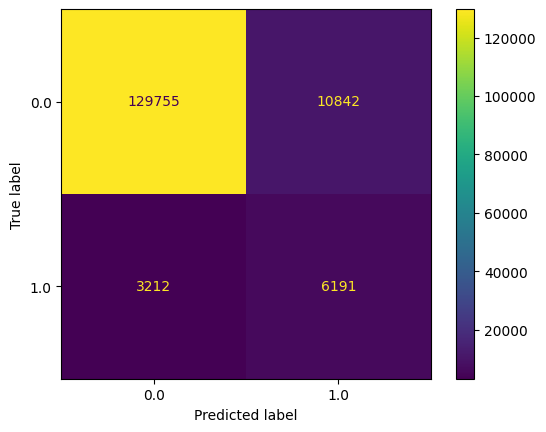

In [21]:
evaluate_model(trained_models['lgbmc'], X_test, y_test, threshold=0.8)


In [ ]:
# load model
with open('Model/trained_models.pcl', 'rb') as fd:
    trained_models = pickle.load(fd)

Accuracy: 0.9464733333333334
F1: 0.443010752688172
Precision: 0.6370710295291301
Recall: 0.3395724768690843
ROC AUC: 0.6633173948603549
AUC: 0.8741229851246646
Classification Report:               precision    recall  f1-score   support

   not churn       0.96      0.99      0.97    140597
       churn       0.64      0.34      0.44      9403

    accuracy                           0.95    150000
   macro avg       0.80      0.66      0.71    150000
weighted avg       0.94      0.95      0.94    150000

ROC Curve: (array([0.        , 0.01293769, 1.        ]), array([0.        , 0.33957248, 1.        ]), array([inf,  1.,  0.]))


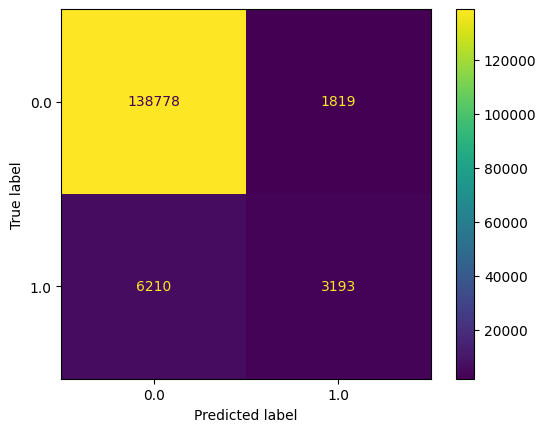

In [22]:
evaluate_model(trained_models['lgbmc_imb'], X_test, y_test)

In [ ]:
y_test.value_counts()

In [ ]:
evaluate_model(trained_models['lgbmc_imb'], X_test, y_test, threshold=0.8)

### let's create a model amsemble

In [ ]:
evaluate_model(trained_models['ensemble'], X_test, y_test, threshold=0.8)

In [ ]:
evaluate_model(trained_models['ensemble'], X_test, y_test)

In [ ]:
# let's make predictions using weighted ensemble
import numpy as np

def weighted_model_assembly(models, maes, X, y):
    """
    Perform weighted model assembly.

    Parameters:
    models (list): List of pre-trained models
    maes (list): List of Mean Absolute Errors corresponding to the models
    X (numpy.ndarray): Input features for prediction

    Returns:
    numpy.ndarray: Weighted predictions
    """
    # Calculate weights inversely proportional to MAE
    weights = np.array([1.0 / mae for mae in maes])
    weights /= np.sum(weights)  # Normalize weights

    # Initialize an array to store weighted predictions
    preds = np.zeros(X.shape[0])

    # Sum the weighted predictions from each model
    for (_, model), weight in zip(models, weights):
        predictions = model.predict_proba(X)[:, 1]
        preds += weight * predictions
    preds = (preds >= 0.5).astype(int)
    
    print(f'Accuracy: {accuracy_score(y, preds)}')
    print(f'F1: {f1_score(y, preds)}')
    print(f'Precision: {precision_score(y, preds)}')
    print(f'Recall: {recall_score(y, preds)}')
    print(f'ROC AUC: {roc_auc_score(y, preds)}')

    auc_score = roc_auc_score(y, model.predict_proba(X)[:,1])
    cm = confusion_matrix(y, preds, labels=model.classes_)
    print(f'AUC: {auc_score}')
    print(f'Classification Report: {classification_report(y, preds, target_names=["not churn", "churn"])}')
    print(f'ROC Curve: {roc_curve(y, preds)}')


    
    # Plot confusion matrix

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

    # TP, FP, FN, TN = cm.ravel()
    # return TP, FP, FN, TN



def evaluate_models(models, X_train, X_val, y_train, y_val):
    # fit and evaluate the models
    scores = list()
    for name, model in models:
        # fit the model
        # model.fit(X_train, y_train)
        # evaluate the model
        yhat = model.predict(X_val)
        mae = mean_absolute_error(y_val, yhat)
        # store the performance
        scores.append(-mae)
        # report model performance
    return scores



In [ ]:
X_train.shape, y_train.shape

In [ ]:
models  = [
    ('xgboost', trained_models['xgboost']),
    ('lgbmc', trained_models['lgbmc']),
    ('rfc', trained_models['rfc']),
    ('lgbmc_imb', trained_models['lgbmc_imb'])

]
scores = evaluate_models(models, X_train_stratified, X_val_stratified, y_train_stratified, y_val_stratified)
# weighted_ensemble(trained_models, X_test, y_test)

In [ ]:
original_scores = scores.copy()
scores[1] = 0.5

In [ ]:
y_test[:1000].value_counts()

In [ ]:
# select 100 rows from X_test

weighted_model_assembly(models, scores.values(), X_test[:1000], y_test[:1000])

In [ ]:
# select 100 rows from X_test

weighted_model_assembly(models, scores, X_test[100:], y_test[100:])

In [ ]:
weighted_model_assembly(models, scores, X_test[100:], y_test[100:])

In [ ]:
import optuna
import numpy as np

def objective(trial):
    # Suggest weights for each model
    weights = [trial.suggest_float(f'weight_{i}', 0, 1) for i in range(len(models))]
    weights = np.array(weights) / np.sum(weights)  # Normalize weights
    
    # Get confusion matrix components
    TP, FP, FN, TN = weighted_model_assembly(models, weights, X_test[1000:], y_test[1000:])
    
    # Define the optimization target
    # We want to maximize TP and TN, and minimize FP and FN
    score = TP + TN - FP - FN
    
    return -score  # Optuna minimizes the objective function, so negate the score

# Optimize weights
study = optuna.create_study()
study.optimize(objective, n_trials=100)

# Get the best weights
best_weights = study.best_trial.params
print("Best weights: ", best_weights)


In [ ]:
scores = {'weight_0': 0.9270322257214373, 'weight_1': 0.8629088399223556, 'weight_2': 0.754293288527458, 'weight_3': 0.07091431790704351}

In [ ]:
weighted_model_assembly(models, list(scores.values()), X_test[100:], y_test[100:])

In [ ]:
y_test.value_counts()

## features after EDA

In [2]:
# load  single value features]
import json
with open(r'Data/features_high_single_ratio.json', 'r') as f:
    features_single = json.load(f)

In [ ]:
# create a function to apply np log to the set of fetures and return the result  as a dataframe  and avoid inf values
def apply_log1p_to_features(X: pd.DataFrame, features: list[str]) -> pd.DataFrame:
    """
    Apply log1p to features
    """
    return X[features].apply(np.log1p)


In [24]:
!pip install catboost

  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 7.7 MB/s eta 0:00:0000:0100:01
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [26]:
# open trained_models.joblib
from joblib import load

cbc = load('Model/cbc.joblib')
lgbmc = load('Model/lgbmc.joblib')
ensemble = load('Model/ensemble_full.joblib')

/Users/andriigerasymchuk/private-repositories/ml-projects/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator VotingClassifier from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [46]:
X_test, y_test = prepare_dataset(df_test_fe, df_test_dpi, df_test_bnum, features=lgbmc.feature_name_)

Accuracy: 0.8889733333333333
F1: 0.4508704827222369
Precision: 0.3267383512544803
Recall: 0.7271083696692545
ROC AUC: 0.8134535425734126
AUC: 0.8978990549718945
Classification Report:               precision    recall  f1-score   support

   not churn       0.98      0.90      0.94    140597
       churn       0.33      0.73      0.45      9403

    accuracy                           0.89    150000
   macro avg       0.65      0.81      0.69    150000
weighted avg       0.94      0.89      0.91    150000

ROC Curve: (array([0.        , 0.10020128, 1.        ]), array([0.        , 0.72710837, 1.        ]), array([inf,  1.,  0.]))


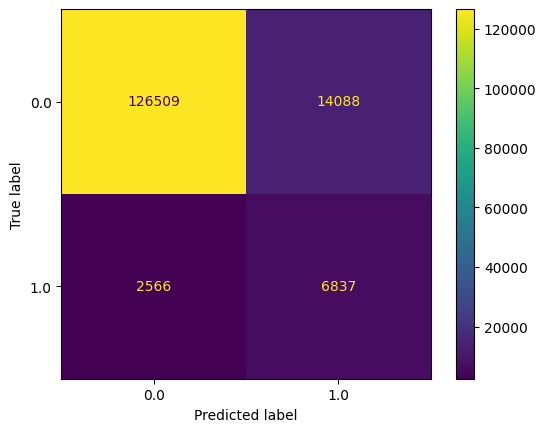

In [49]:
evaluate_model(ensemble, X_test, y_test)

 